In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import os
import json

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torchvision

In [3]:
import deepmorph.distributed
import deepmorph.vqvae.train_vqvae_protein_and_condition
import deepmorph.data.dataset

In [4]:
os.environ["OMP_NUM_THREADS"] = "16"

args = {
    'output_path': 'test_output', 
    'device' : 'cuda',
    'train_data_path' : '/home/xingjiepan/Data/20230313_deep_morph_test_data_splitted/train',
    'validation_data_path': '/home/xingjiepan/Data/20230313_deep_morph_test_data_splitted/validation',
    'fiducial_channel': 3, # The channel ID of DAPI
    'n_categories' : 37, # Number of protein channels
    'n_conditions' : 4, # Number of cell conditions
    'img_xy_shape' : (128, 128),
    'normalization_factor' : 1,
    'batch_size' : 64,
    'lr': 3e-4,
    'anneal_lr': True,
    'epoch': 200,
    'n_stop_threhold': 20,
    
    
    #'checkpoint_to_resume': 'test_output/check_points/vqvae_best.pt',
    #'log_file_to_resume': 'test_output/loss_history.json',
    }

deepmorph.distributed.launch(deepmorph.vqvae.train_vqvae_protein_and_condition.build_model_and_train, 
                             n_gpu_per_machine=2, n_machine=1, machine_rank=0, 
                             dist_url='auto', args=(args,))

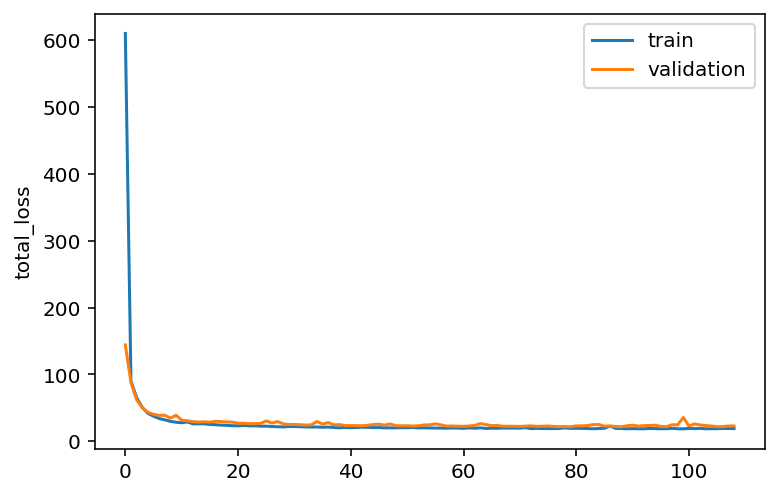

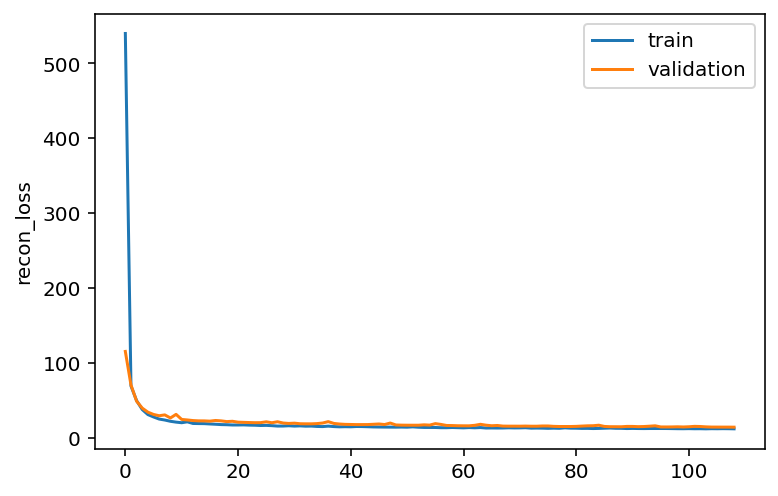

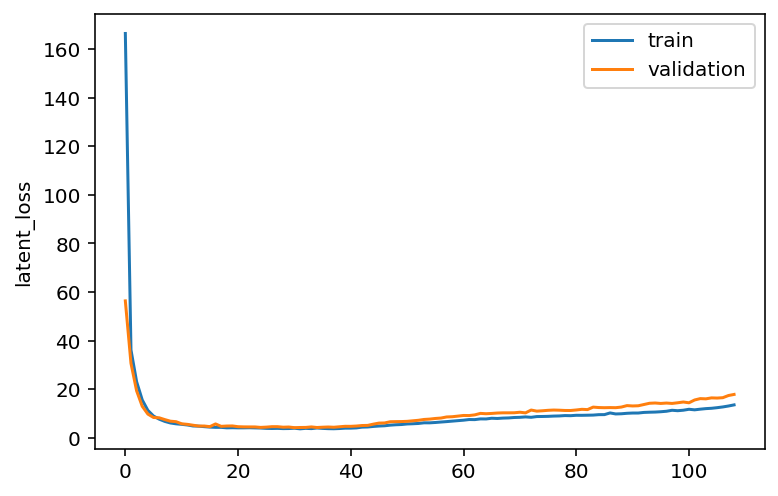

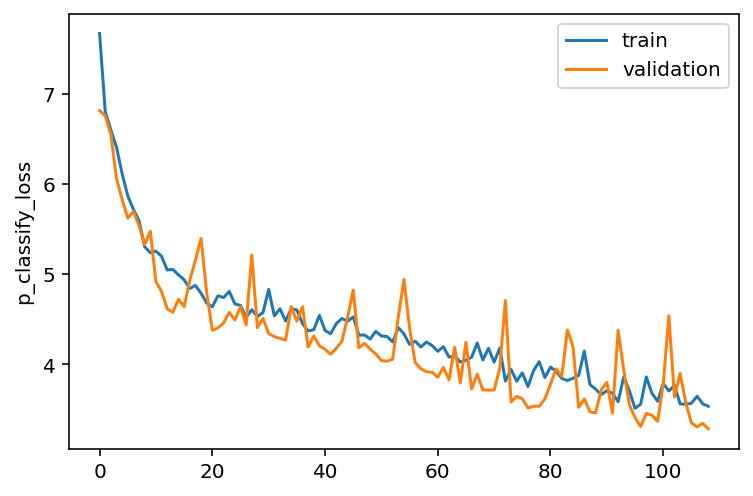

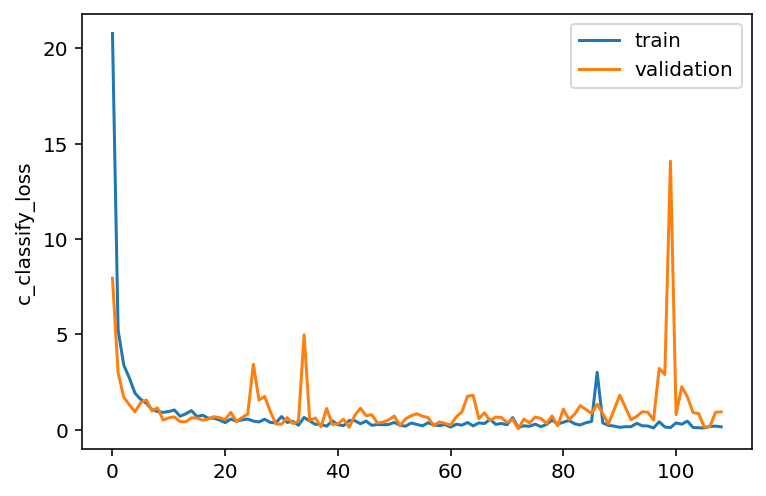

In [5]:
with open(os.path.join(args['output_path'], 'loss_history.json'), 'r') as f:
    loss_history = json.load(f)

imin, imax = 0, 1000
for k in ['total_loss', 'recon_loss', 'latent_loss', 'p_classify_loss', 'c_classify_loss']:
    iters = np.arange(len(loss_history['train_' + k]))
    plt.plot(iters[imin:imax], loss_history['train_' + k][imin:imax], label='train')
    plt.plot(iters[imin:imax], loss_history['val_' + k][imin:imax], label='validation')
    plt.ylabel(k)
    plt.legend()
    plt.show()

# Reconstruction example

In [6]:
pretrained_dict = torch.load(os.path.join(args['output_path'], 'check_points', 'vqvae_latest.pt'))
pretrained_dict = {key.replace("module.", ""): value for key, value in pretrained_dict.items()}

model = deepmorph.vqvae.vqvae.VQVAE(in_channel=2,
                                    channel=32,
                                    n_res_block=2,
                                    n_res_channel=16,
                                    embed_dim=32,
                                    n_embed=256,
                                    classifier_hidden_dim=512, 
                                    n_categories=37,
                                    n_conditions=4,
                                    img_xy_shape=(128, 128))
model.load_state_dict(pretrained_dict)


device = 'cuda'
model.to(device)
model.eval()
pass

In [7]:
dataset = deepmorph.data.dataset.DiskDataset('/home/xingjiepan/Data/20230313_deep_morph_test_data',
                                            normalize_img=False)


<ipython-input-8-650b1c49cf8c>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/torch/csrc/utils/tensor_new.cpp:230.)
  sample = torch.tensor([dataset[-100][0]], dtype=torch.float32).to(device)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


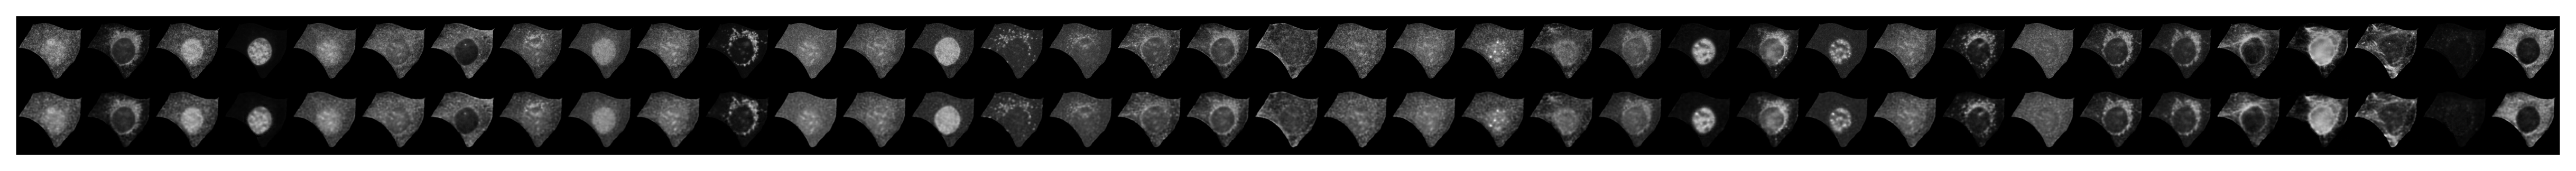

In [8]:
with torch.no_grad():
    sample = torch.tensor([dataset[-100][0]], dtype=torch.float32).to(device)
    output, _, _, _ = model(torch.cat((sample.reshape(37, 1, 128, 128), 
                    torch.repeat_interleave(sample[:, [3], :, :], sample.shape[1], dim=0)), 
                                      dim=1))

    
grid_img = torchvision.utils.make_grid(
    torch.cat([sample.permute(1, 0, 2, 3), 
               output[:, [0], :, :].reshape(1, 37, 128, 128).permute(1, 0, 2, 3)], 0).to('cpu')
    , nrow=37)

fig, ax = plt.subplots(figsize=(20, 8), dpi=300)
ax.imshow(grid_img.permute(1, 2, 0) / 255)
ax.set_axis_off()